# Task Space Decomposition via Convex Optimization

One approach to guaranteeing safe paths during motion planning is to certify that large regions in the search space are collision free. In this problem we'll explore one algorithm, [IRIS](https://groups.csail.mit.edu/robotics-center/public_papers/Deits14.pdf), for accomplishing this.
For manipulation planning, we typically want to certify paths in configuration space.  Simple convex obstacles in 3D become nonconvex when we map them into the joint space of the iiwa!  But for this problem, we'll explore the more straightforward version of IRIS which assumes that obstacles are convex, in a 2D space.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Ellipse
from matplotlib.transforms import Affine2D
from scipy.spatial import HalfspaceIntersection

from matplotlib.animation import FuncAnimation

from pydrake.all import (
    MathematicalProgram, Solve, eq, le, ge,
    ConvexSet,
    HPolyhedron,

)

import pydrake.geometry.optimization as mut

from underactuated import running_as_notebook

We'll start with some helper functions to set up the environment with our obstacles (we are using a random set of triangles) along with some plotting functions

In [3]:
obstacles = [mut.Point([0,0])]
# obstacles = []
domain = HPolyhedron.MakeUnitBox(2)
sample = np.array([0.5,0.5])
region = mut.Iris(obstacles,sample,domain)

# print(region)
# print(region.b())

# print("yay")

# print(domain.A())
# print(domain.b())


Vpoly = mut.VPolytope(region)
vert = Vpoly.vertices()
print(vert) 

[[ 1.          1.         -1.         -1.        ]
 [-0.99966327  1.          0.99966327  1.        ]]


In [4]:
#####################
### Don't change! ###

np.random.seed(1)

seed_point = None
As = []
bs = []
Cs = []
ds = []
tolerance = 0.00001
limits = [[-2, 2], [-2, 2]]
max_iters = 10

frame_time = 0.25

regions = []
current_region = []

#######################


# As.append(region.A().transpose())
# bs.append(region.b())
# ds.append(np.array([0, 0]))
regions.append(vert.T)


# Function to set up random set of triangle obstacles
def gen_obstacles():
    n_points = 50

    points = np.random.random(size=(n_points, 2))

    tris = []
    # for i, pt in enumerate(points):
    #     r = np.random.random() * 0.06 + 0.03
    #     delta1 = r * np.array([np.cos(np.pi / 2), np.sin(np.pi / 2)])
    #     delta2 = r * np.array(
    #         [
    #             np.cos(2 * np.pi / 3 + np.pi / 2),
    #             np.sin(2 * np.pi / 3 + np.pi / 2),
    #         ]
    #     )
    #     delta3 = r * np.array(
    #         [
    #             np.cos(4 * np.pi / 3 + np.pi / 2),
    #             np.sin(4 * np.pi / 3 + np.pi / 2),
    #         ]
    #     )

    #     tris.append(np.vstack([pt + delta1, pt + delta2, pt + delta3]))

    # tris.append(np.array([[0, 0], [1, 0], [0.5, -0.5]]))
    # tris.append(np.array([[1, 0], [1, 1], [1.5, 0.5]]))
    # tris.append(np.array([[1, 1], [0, 1], [0.5, 1.5]]))
    # tris.append(np.array([[0, 1], [0, 0], [-0.5, 0.5]]))

    return tris


# plotting to draw an ellipse
def draw_ellipse(C, d):
    ts = np.linspace(0, 2 * np.pi)
    points = np.array([np.cos(ts), np.sin(ts)])
    points = C @ points + d.reshape(-1, 1)
    ax.plot(*(points))


# plotting to draw intersection of halfspaces
def draw_intersection(A, b, d):
    global current_region
    print(A.size)
    print(b.size)
    ineq = np.hstack((A.T, -b))
    hs = HalfspaceIntersection(ineq, d, incremental=False)
    points = hs.intersections
    centered_points = points - d
    thetas = np.arctan2(centered_points[:, 1], centered_points[:, 0])
    idxs = np.argsort(thetas)
    current_region = points[idxs]
    ax.add_patch(Polygon(current_region, color="blue", alpha=0.25))


# plotting
def draw(ax):
    global seed_point, As, bs, Cs, ds, regions
    ax.cla()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    for tri in tris:
        ax.add_patch(Polygon(tri, color="red"))
    if not (seed_point is None):
        ax.scatter([seed_point[0]], [seed_point[1]])
    if len(Cs) > 0:
        C = Cs[-1]
        d = ds[-1]
        draw_ellipse(C, d)
    if len(As) > 0:
        A = As[-1]
        b = bs[-1]
        for i in range(len(b)):
            w = A[:, i]
            intercept = b[i]
            xx = np.linspace(*limits[0])
            yy = (-w[0] / w[1]) * xx + (intercept / w[1])
            ax.plot(xx, yy, color="blue")
        draw_intersection(A, b, ds[-1])
    for region in regions:
        plt.plot(region[:, 0], region[:, 1], color="green", alpha=0.5)
        plt.plot(
            region[[0, -1], 0], region[[0, -1], 1], color="green", alpha=0.5
        )
        ax.add_patch(Polygon(region, color="green", alpha=0.25))

In [72]:
# print(tris[0].size)
# print(tris[0])

# print(As[-1][:,3])
# print(ds[-1])
print(region.A()[:,1])
# print(len(bs[-1]))

[ 0.  1. -0. -1.]


Run the cell below to see what the random workspace looks like!

Before sort:  [[ 1.          1.         -1.         -1.        ]
 [-0.99966327  1.          0.99966327  1.        ]]
After sort:  [array([-1.        ,  0.99966327]), array([-1.,  1.]), array([ 1.        , -0.99966327]), array([1., 1.])]
[-1.          0.99966327]
[-1.  1.]
[ 1.         -0.99966327]
[1. 1.]


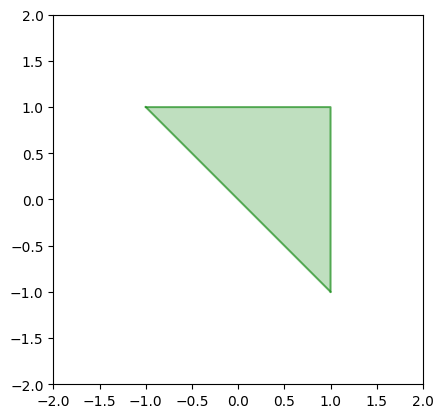

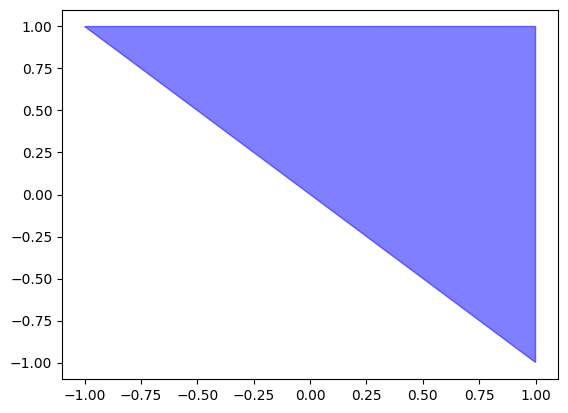

: 

In [126]:
tris = gen_obstacles()
 
fig, ax = plt.subplots()
draw(ax)


fig, ax = plt.subplots()


print("Before sort: ", vert)
vert = sorted(vert.T, key=lambda x: x[0])

print("After sort: ", vert)
 
x = [v[0] for v in vert]
y = [v[1] for v in vert]

for v in vert:
    print(v)
    
plt.fill(x,y, color='blue', alpha=0.5)

True
True
False


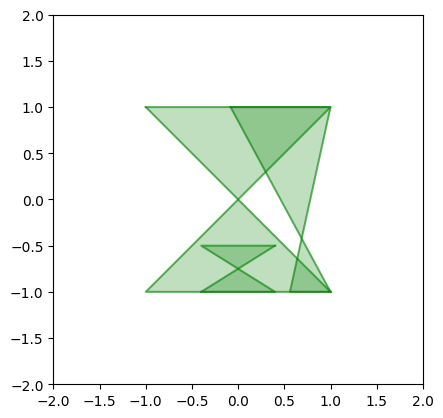

In [26]:
regions = []

#######################

obstacles = [ mut.VPolytope.MakeBox([-.4,-1],[.4, -.5])]
# obstacles = []
domain = HPolyhedron.MakeUnitBox(2)
sample = np.array([.45,-.95])

option = mut.IrisOptions()
option.require_sample_point_is_contained = True

region = mut.Iris(obstacles,sample,domain)

# print(region)
# print(region.b())

# print("yay")

# print(domain.A())
# print(domain.b())


Vpoly = mut.VPolytope(region)
vert = Vpoly.vertices()
regions.append(vert.T)

Vpoly = mut.VPolytope(domain)
vert = Vpoly.vertices()
regions.append(vert.T)

vert = obstacles[0].vertices()
regions.append(vert.T)


# As.append(region.A().transpose())
# bs.append(region.b())
# ds.append(np.array([0, 0]))


tris = gen_obstacles()
 
fig, ax = plt.subplots()
draw(ax)

print(region.PointInSet([0.3,0]))
print(region.PointInSet([0.99,.99]))
print(region.PointInSet(sample))

print(obstacles)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f04667bf-32a3-4462-9e65-eda0faf36cb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>